# importing all libraries

In [2]:
import os
import re
import sys
import nltk
import itertools
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn import tree
from sklearn.svm import SVC
from joblib import dump, load
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# from keras.models import Sequential,Model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
# from keras.utils.np_utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
# from keras.layers import Dense,LSTM, SpatialDropout1D, Embedding

# Reading the Dataset

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/nathnaeltk/ml-resume-screening-and-job-matching/main/Resume.csv')
df.drop(df.columns[[0, 2]], axis=1, inplace=True)
df = df[['Category', 'Resume_str']]
df.columns = ['Category', 'Resume']


df.head()

,Category,Resume
0,HR,HR ADMINISTRATOR/MARKETING ASSOCIATE\...
1,HR,"HR SPECIALIST, US HR OPERATIONS ..."
2,HR,HR DIRECTOR Summary Over 2...
3,HR,HR SPECIALIST Summary Dedica...
4,HR,HR MANAGER Skill Highlights ...


# List of all Categories

In [5]:
for i in range(len(df['Category'].unique())):
    print(df['Category'].unique()[i])

HR
DESIGNER
INFORMATION-TECHNOLOGY
TEACHER
ADVOCATE
BUSINESS-DEVELOPMENT
HEALTHCARE
FITNESS
AGRICULTURE
BPO
SALES
CONSULTANT
DIGITAL-MEDIA
AUTOMOBILE
CHEF
FINANCE
APPAREL
ENGINEERING
ACCOUNTANT
CONSTRUCTION
PUBLIC-RELATIONS
BANKING
ARTS
AVIATION


# Visualizing most commonly used words in each type of Resumes

KeyboardInterrupt: 

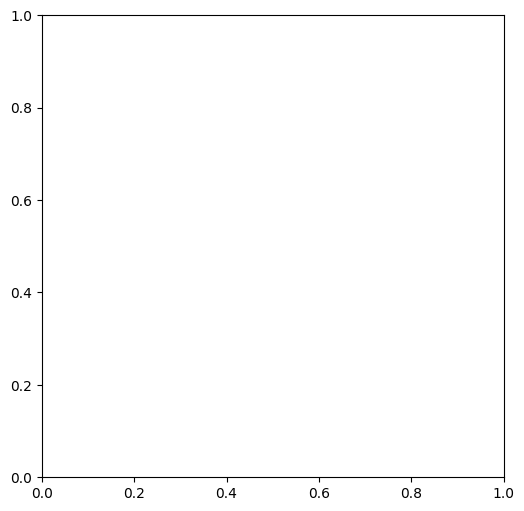

In [6]:
a=[ 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r','BrBG_r', 'BuGn', 'BuGn_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'crest_r']
for label, cmap in zip(df['Category'].unique(), a):
    text = df.query("Category == @label")["Resume"].str.cat(sep=" ")
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Resumes", size=20)
    plt.show()

# Pre Processing

# Checking for missing data

In [7]:
print(df.isnull().sum())

Category    0
Resume      0
dtype: int64


# Converting the data into lower case and removing words with small lengths

In [8]:
df['Resume'] = df['Resume'].apply(lambda x:x.lower())
for i in range(len(df)):
    lw=[]
    for j in df['Resume'][i].split():
        if len(j)>=3:                  
            lw.append(j)
    df['Resume'][i]=" ".join(lw)

C:\Users\Yordanos\AppData\Local\Temp\ipykernel_9312\4277992297.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Resume'][i]=" ".join(lw)
C:\Users\Yordanos\AppData\Local\Temp\ipykernel_9312\4277992297.py:7: FutureWarning: ChainedAssign

# removing punctuations

In [9]:
ps = list(";?.:!,")
df['Resume'] = df['Resume']

for p in ps:   
    df['Resume'] = df['Resume'].str.replace(p, '')

# Removing '\n' and '\t', extra spaces, quoting text and progressive pronouns

In [10]:
df['Resume'] = df['Resume'].str.replace("    ", " ")
df['Resume'] = df['Resume'].str.replace('"', '')
df['Resume'] = df['Resume'].apply(lambda x: x.replace('\t', ' '))
df['Resume'] = df['Resume'].str.replace("'s", "")
df['Resume'] = df['Resume'].apply(lambda x: x.replace('\n', ' '))

# Applying Lemmatization

In [11]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yordanos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yordanos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Yordanos\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

lemmatization on the text data in the Resume column

In [12]:
wl = WordNetLemmatizer()
nr = len(df)
lis = []
for r in range(0, nr):
    ll = []
    t = df.loc[r]['Resume']
    tw = str(t).split(" ")
    for w in tw:
        ll.append(wl.lemmatize(w, pos="v"))
    lt = " ".join(ll)
    lis.append(lt)

In [13]:
df['Resume'] = lis

# Removing Stop-words

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yordanos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
sw = list(stopwords.words('english'))
for s in sw:
    rs = r"\b" + s + r"\b"
    df['Resume'] = df['Resume'].str.replace(rs, '')

# Visualizing most commonly used words in Resumes after applying NLP techniques 

In [ ]:
a=[ 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r','BrBG_r', 'BuGn', 'BuGn_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'crest_r','Accent_r', 'Blues', 'Blues_r', 'BrBG', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r','BrBG_r', 'BuGn', 'BuGn_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr']
for label, cmap in zip(df['Category'].unique(), a):
    text = df.query("Category == @label")["Resume"].str.cat(sep=" ")
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Resumes", size=20)
    plt.show()

In [18]:
df.iloc[1,1]

'education detail may 2013 may 2017 be uit-rgpv data scientist data scientist matelabs skill detail python- exprience less than year months statsmodels- exprience months aws- exprience less than year months machine learning- exprience less than year months sklearn- exprience less than year months scipy- exprience less than year months keras- exprience less than year monthscompany detail company matelabs description platform for business professionals dummy and enthusiasts 60/a koramangala 5th block achievements/tasks behind sukh sagar bengaluru india develop and deploy auto preprocessing step machine learn mainly miss value treatment outlier detection encode scale feature selection and dimensionality reduction deploy automate classification and regression model linkedincom/in/aditya-rathore- b4600b146 reasearch and deploy the time series forecast model arima sarimax holt-winter and prophet work meta-feature extract problem githubcom/rathorology implement state the art research paper ou

# Data Preparation for Training and Testing

# Encoding Labels

In [16]:
c = LabelEncoder()
df['Category'] = c.fit_transform(df['Category'])
le_name_mapping = dict(zip( c.transform(c.classes_),c.classes_))
print(le_name_mapping)

{np.int64(0): 'ACCOUNTANT', np.int64(1): 'ADVOCATE', np.int64(2): 'AGRICULTURE', np.int64(3): 'APPAREL', np.int64(4): 'ARTS', np.int64(5): 'AUTOMOBILE', np.int64(6): 'AVIATION', np.int64(7): 'BANKING', np.int64(8): 'BPO', np.int64(9): 'BUSINESS-DEVELOPMENT', np.int64(10): 'CHEF', np.int64(11): 'CONSTRUCTION', np.int64(12): 'CONSULTANT', np.int64(13): 'DESIGNER', np.int64(14): 'DIGITAL-MEDIA', np.int64(15): 'ENGINEERING', np.int64(16): 'FINANCE', np.int64(17): 'FITNESS', np.int64(18): 'HEALTHCARE', np.int64(19): 'HR', np.int64(20): 'INFORMATION-TECHNOLOGY', np.int64(21): 'PUBLIC-RELATIONS', np.int64(22): 'SALES', np.int64(23): 'TEACHER'}


# Using TFIDF approach for converting the content in Resumes into vector form

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features=20000)
X = cv.fit_transform(df['Resume'])
y = df['Category']

In [18]:
a = cv.get_feature_names_out()

In [19]:
import pickle

filename = 'cv.pickle'

# Saving the cv (TfidfVectorizer) object using pickle
pickle.dump(cv, open(filename, 'wb'))


In [20]:
X.shape,y.shape

((2484, 20000), (2484,))

In [21]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
smk = SMOTETomek(random_state=42)
X_res,y_res=smk.fit_resample(X,df['Category'])

In [25]:
X_res.shape,y_res.shape

((2100, 6762), (2100,))

# Splitting the Data using Stratified split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.25, stratify=y_res, random_state = 42)

In [24]:
X_train.shape,y_train.shape

((2134, 20000), (2134,))

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.Greens):
    plt.figure(figsize=(50, 20), dpi=130)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
print(X_test[0].shape)

(1, 20000)


# Using KNeighbors Classifier as the Model and printing evaluating it using confusion matrix

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
model1=KNeighborsClassifier()
clf1=GridSearchCV(model1,{'n_neighbors':[1,2,3,4,5,6,7,8,9,10]})
clf1.fit(X_res,y_res)
clf1.cv_results_

{'mean_fit_time': array([0.01387401, 0.01637669, 0.00987906, 0.01660743, 0.01475902,
        0.01823807, 0.01332521, 0.01528487, 0.01569943, 0.00905232]),
 'std_fit_time': array([0.00779644, 0.00087142, 0.00811805, 0.00088933, 0.0082038 ,
        0.00830994, 0.00511331, 0.00848122, 0.00244319, 0.00758401]),
 'mean_score_time': array([0.61705899, 0.5810523 , 0.5634017 , 0.59046607, 0.54298644,
        0.63376317, 0.70579667, 0.6447484 , 0.68080521, 0.54408336]),
 'std_score_time': array([0.09255052, 0.021111  , 0.0428171 , 0.06911184, 0.0306539 ,
        0.13840858, 0.11409054, 0.08061858, 0.16702108, 0.10171887]),
 'param_n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 2},
  {'n_neighbors': 3},
  {'n_neighbors': 4},
  {'n_neighbors': 5},
  {'n_neighbors': 6},
  {'n_neighbors': 7},
  

In [29]:
# View the best parameters and score
print("Best parameters:", clf1.best_params_)
print("Best score:", clf1.best_score_)

Best parameters: {'n_neighbors': 1}
Best score: 0.41778312212869606


In [30]:
pd1=pd.DataFrame(clf1.cv_results_)
pd1.to_csv('Knn.csv')

In [31]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf1 = clf1.fit(X_train, y_train)
yp = clf1.predict(X_test)
acc = accuracy_score(y_test, yp)
print("accuracy is: ",acc)


accuracy is:  0.42275280898876405


In [34]:

# Example: Custom CV/resume text
custom_cv = """
Yordanos Yeshitla
+251-93039-3733 | yordiman614@gmail.com | linkedin.com/in/yordanos-yeshitla | github.com/yordiyes
Education
Haramaya University Haramaya, Ethiopia
BSc in Software Engineering 2021 – 2026
Experience
Web Development Intern July 2024 – August 2024
Prodigy InfoTech Remote
– Designed and developed responsive web applications using HTML, CSS, and JavaScript.
– Collaborated with a team to build dynamic web components.
Web Development Intern June 2024 – July 2024
CodeSoft Remote
– Worked on front-end tasks using HTML, CSS, and React.
– Built reusable UI components and maintained cross-browser compatibility.
Projects
Web Dashboard for Student Projects
Technologies: Node.js, MongoDB, Tailwind CSS
Chat App
Technologies: React, Node.js, MongoDB
Spam Email Detection Model
Technologies: Machine Learning, Python
E-learning Site Projects
Technologies: Node.js, Express, MongoDB, Tailwind CSS (In Progress)
Task-Management Site
Technologies: Node.js, MongoDB, Tailwind CSS (In Progress)
Typing Test Website
Technologies: HTML, CSS, JavaScript (In Progress)
Technical Skills
Programming Languages: Python, JavaScript, Java, C++
Web Development: HTML, CSS, Tailwind CSS, React, Node.js, Express.js, Vite
Databases: PostgreSQL, MongoDB
Tools: Git
Certifications
HTML, CSS, and JavaScript for Web Developers (Coursera – John Hopkins University)
Introduction to Back-End Development (Coursera)
Programming with JavaScript (Coursera)
Java Programming for Beginners (SimpliLearn)
PostgreSQL : Become an SQL Developer (SimpliLearn)
SQL Intermediate (SoloLearn)
Reference
Nathnael Teketel +251-996904151
Addis Ababa
"""

# Step 1: Vectorize the custom CV text
# Ensure the vectorizer is the same one used during training
# Example: If you used TfidfVectorizer during training, load or reuse it here
#  vectorizer = TfidfVectorizer()  # Replace with your actual vectorizer
X_custom = cv.transform([custom_cv])  # Transform the text into numerical features

# Step 2: Make a prediction
predicted_job = clf1.predict(X_custom)

actual_job_name = le_name_mapping.get(predicted_job[0], "Unknown Job")

# Step 3: Output the predicted job
print("Predicted Job:", actual_job_name)

Predicted Job: BUSINESS-DEVELOPMENT


In [ ]:
yc = clf1.predict(X_res)
CM = confusion_matrix(y_res, yc)
plot_confusion_matrix(CM, classes = range(48),cmap=plt.cm.Blues)
dump(clf1, 'knei.joblib') 

In [36]:
from sklearn.metrics import precision_recall_fscore_support
s1 = precision_recall_fscore_support(y_res, yc,average='weighted')
s1

(1.0, 1.0, 1.0, None)

# Using Decision tree as the Model and printing evaluating it using confusion matrix

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model2=DecisionTreeClassifier()
clf2=GridSearchCV(model2,{'max_depth':[10,20,30,40,50,60,70,80,90,100]},cv=5)
clf2.fit(X_res,y_res)
clf2.cv_results_

In [45]:
pd2=pd.DataFrame(clf2.cv_results_)
pd2.to_csv('DT.csv')

In [ ]:
clf2 = tree.DecisionTreeClassifier(max_depth=100)
clf2 = clf2.fit(X_train, y_train)
yp = clf2.predict(X_test)
acc = accuracy_score(y_test, yp)
print("accuracy is: ",acc)
CM = confusion_matrix(y_test, yp)
plot_confusion_matrix(CM, classes = range(48))
dump(clf2, 'DT.joblib') 

In [47]:

# Example: Custom CV/resume text
custom_cv = """
Yordanos Yeshitla
+251-93039-3733 | yordiman614@gmail.com | linkedin.com/in/yordanos-yeshitla | github.com/yordiyes
Education
Haramaya University Haramaya, Ethiopia
BSc in Software Engineering 2021 – 2026
Experience
Web Development Intern July 2024 – August 2024
Prodigy InfoTech Remote
– Designed and developed responsive web applications using HTML, CSS, and JavaScript.
– Collaborated with a team to build dynamic web components.
Web Development Intern June 2024 – July 2024
CodeSoft Remote
– Worked on front-end tasks using HTML, CSS, and React.
– Built reusable UI components and maintained cross-browser compatibility.
Projects
Web Dashboard for Student Projects
Technologies: Node.js, MongoDB, Tailwind CSS
Chat App
Technologies: React, Node.js, MongoDB
Spam Email Detection Model
Technologies: Machine Learning, Python
E-learning Site Projects
Technologies: Node.js, Express, MongoDB, Tailwind CSS (In Progress)
Task-Management Site
Technologies: Node.js, MongoDB, Tailwind CSS (In Progress)
Typing Test Website
Technologies: HTML, CSS, JavaScript (In Progress)
Technical Skills
Programming Languages: Python, JavaScript, Java, C++
Web Development: HTML, CSS, Tailwind CSS, React, Node.js, Express.js, Vite
Databases: PostgreSQL, MongoDB
Tools: Git
Certifications
HTML, CSS, and JavaScript for Web Developers (Coursera – John Hopkins University)
Introduction to Back-End Development (Coursera)
Programming with JavaScript (Coursera)
Java Programming for Beginners (SimpliLearn)
PostgreSQL : Become an SQL Developer (SimpliLearn)
SQL Intermediate (SoloLearn)
Reference
Nathnael Teketel +251-996904151
Addis Ababa
"""

# Step 1: Vectorize the custom CV text
# Ensure the vectorizer is the same one used during training
# Example: If you used TfidfVectorizer during training, load or reuse it here
#  vectorizer = TfidfVectorizer()  # Replace with your actual vectorizer
X_custom = cv.transform([custom_cv])  # Transform the text into numerical features

# Step 2: Make a prediction
predicted_job = clf1.predict(X_custom)

actual_job_name = le_name_mapping.get(predicted_job[0], "Unknown Job")

# Step 3: Output the predicted job
print("Predicted Job:", actual_job_name)

Predicted Job: DotNet Developer


In [44]:
yp2 = clf2.predict(X_res)

In [45]:
from sklearn.metrics import precision_recall_fscore_support
s2 = precision_recall_fscore_support(y_res, yp2,average='weighted')
s2

(1.0, 1.0, 1.0, None)

# Using Random Forest Classifier as the Model and printing evaluating it using confusion matrix

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model3=RandomForestClassifier()
clf3=GridSearchCV(model3,{'n_estimators':[10,50,100,300,500]},cv=5)
clf3.fit(X_res,y_res)

In [ ]:
clf3.best_estimator_

In [48]:
pd3=pd.DataFrame(clf3.cv_results_)
pd3.to_csv('RF.csv')

In [49]:
clf4=RandomForestClassifier(n_estimators = 500)
clf4 = clf4.fit(X_train, y_train)
yp = clf4.predict(X_test)
acc = accuracy_score(y_test, yp)
print("accuracy is: ",acc)
dump(clf4, 'RF.joblib') 

accuracy is:  1.0


['RF.joblib']

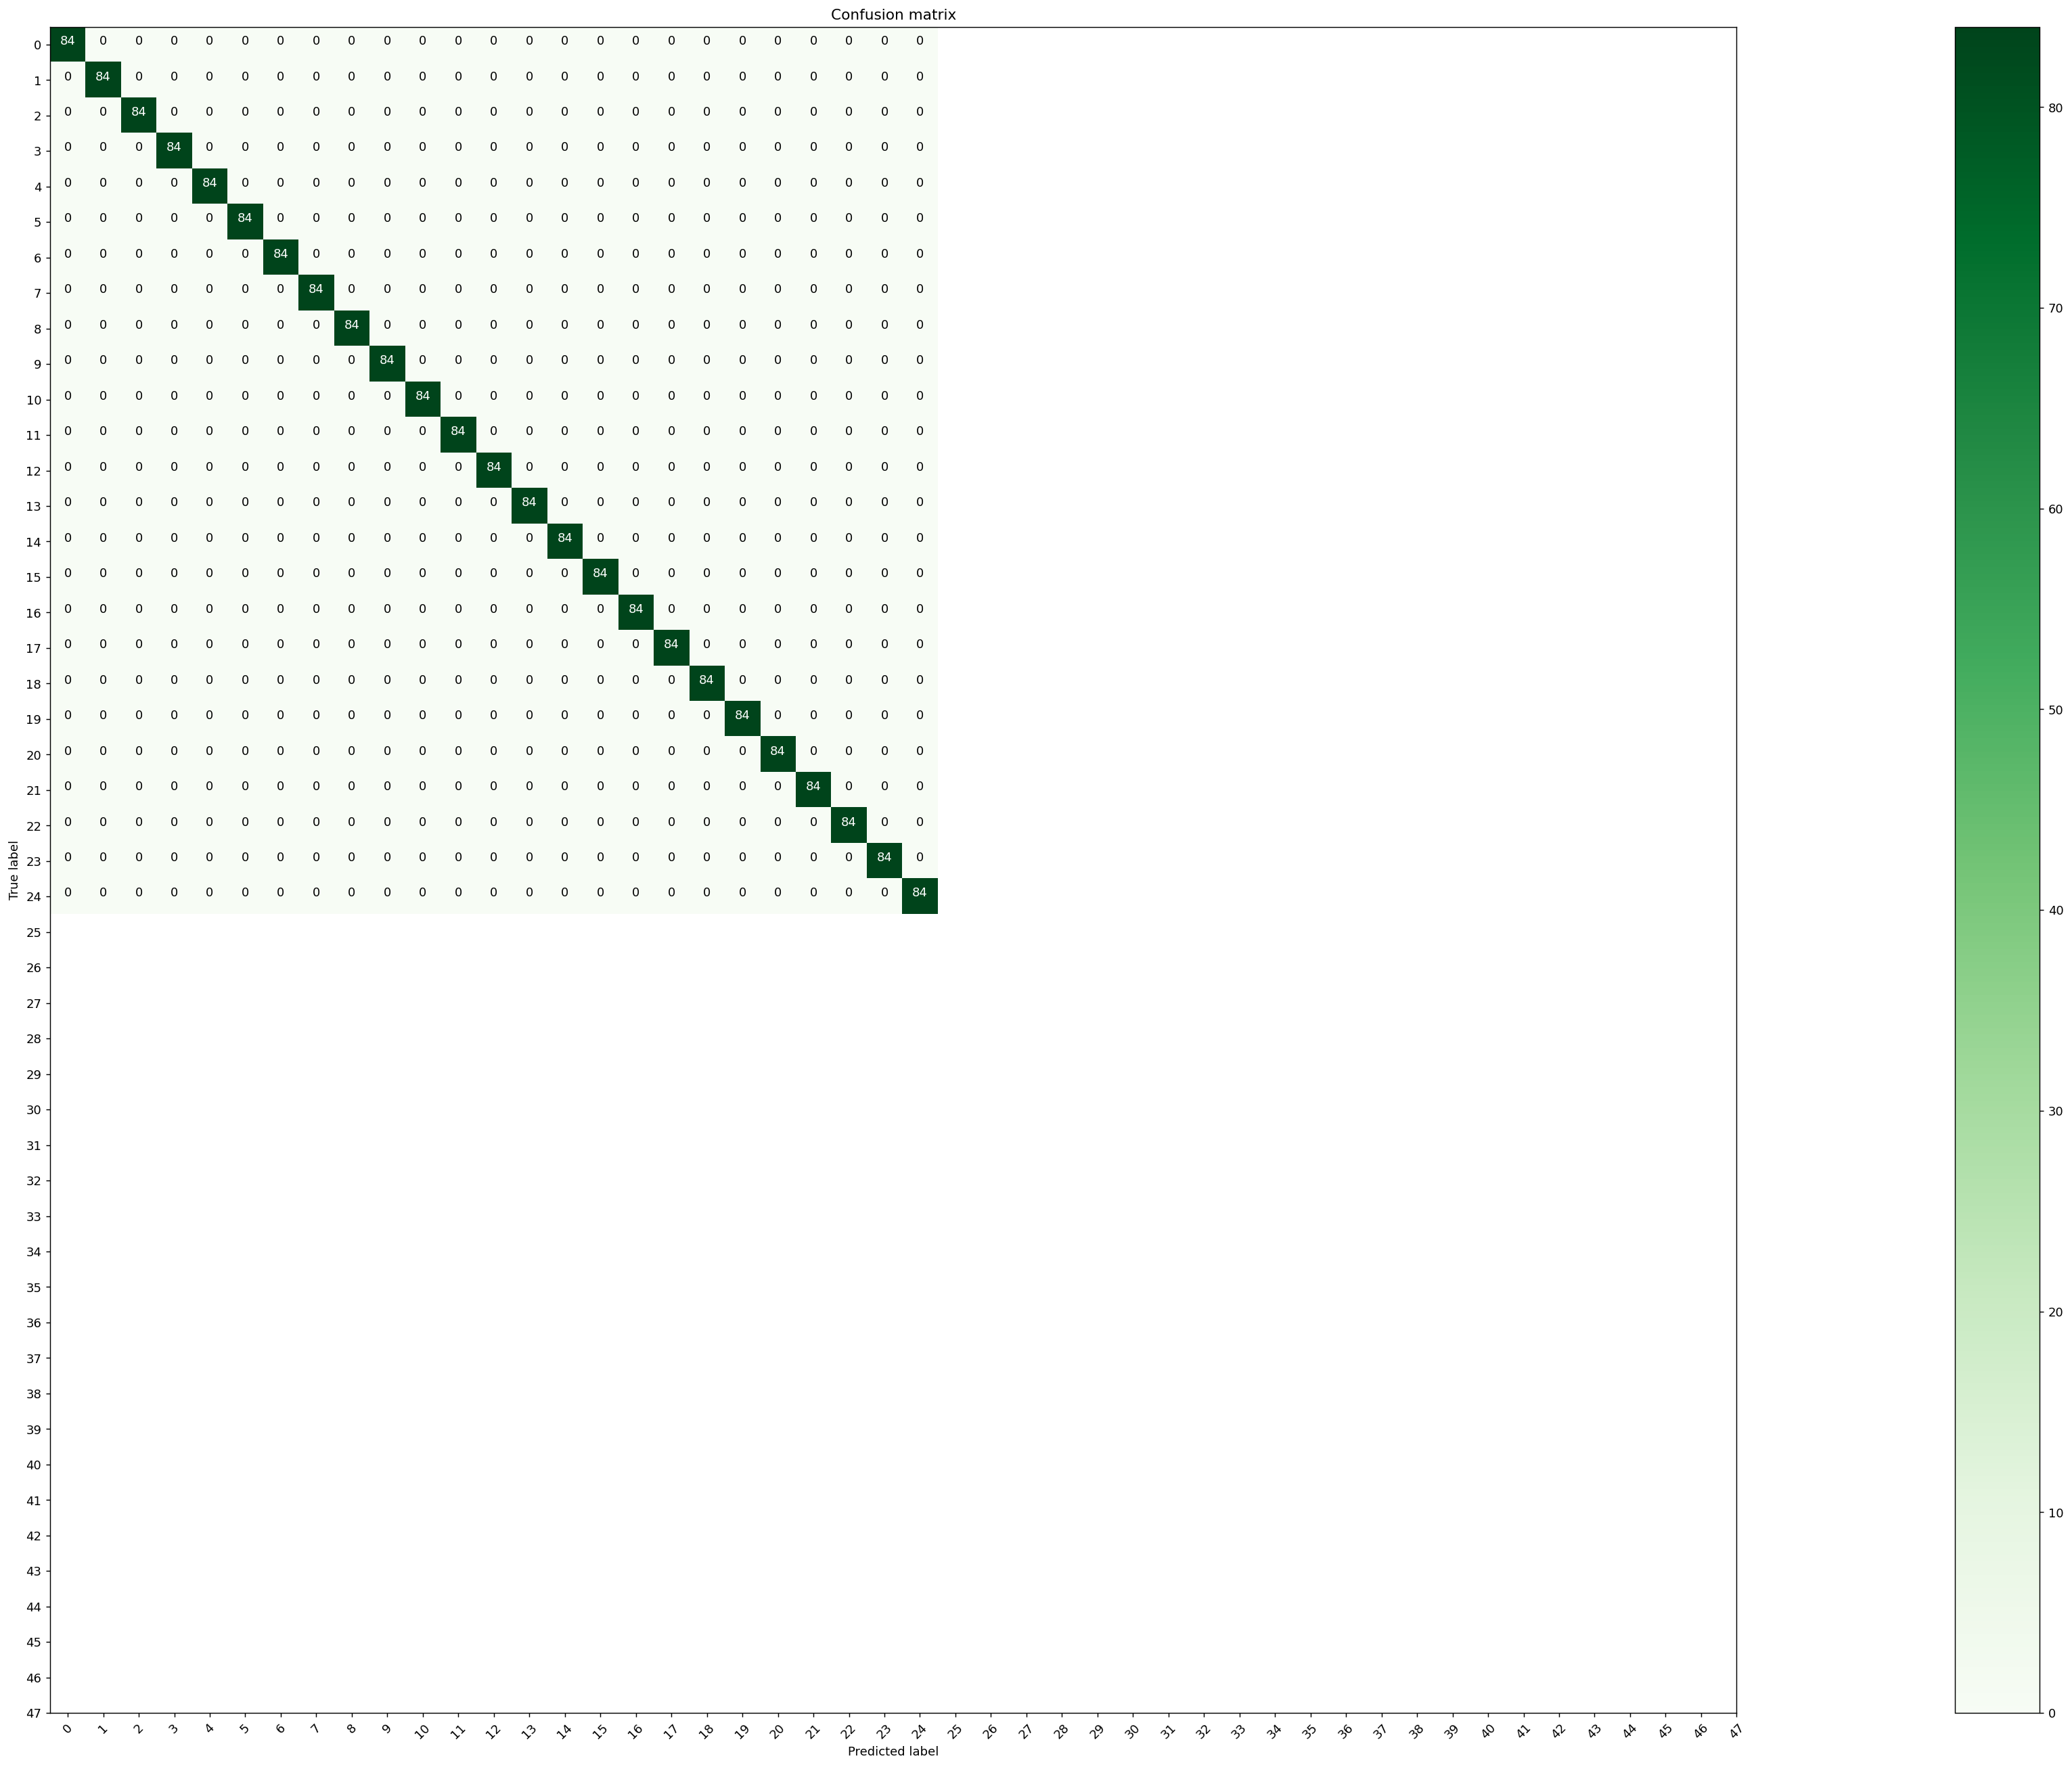

In [50]:
yp4 = clf4.predict(X_res)
CM = confusion_matrix(y_res, yp4)
plot_confusion_matrix(CM, classes = range(48))

In [51]:
from sklearn.metrics import precision_recall_fscore_support
s3 = precision_recall_fscore_support(y_res, yp4,average='weighted')
s3

(1.0, 1.0, 1.0, None)

# Using Support Vector Classifier (SVC) as the Model and printing evaluating it using confusion matrix

In [52]:
from sklearn.svm import SVC
model4=SVC()
clf4 = GridSearchCV(model4,{'C':[0.01,0.1,0.5,1],'kernel':['linear','poly','rbf','sigmoid']})
clf4.fit(X_res,y_res)
clf4.cv_results_

{'mean_fit_time': array([10.80063472,  9.90134039,  9.81052656,  9.87530761,  5.81456857,
         6.56523719,  6.63785605,  6.99885678,  1.9808136 ,  2.20266819,
         1.92745876,  2.06188745,  1.1078135 ,  1.61118226,  1.14069257,
         1.10642247]),
 'std_fit_time': array([0.85047007, 0.55410606, 1.50403603, 0.56806252, 0.47761028,
        0.63808554, 1.25506224, 1.47623327, 0.16414162, 0.14003544,
        0.12426554, 0.10262931, 0.14644888, 0.14917642, 0.08703845,
        0.04164957]),
 'mean_score_time': array([1.70768628, 1.66734986, 1.55374751, 1.44926891, 1.24016128,
        1.44770255, 1.17737689, 1.5415029 , 0.54289317, 0.53275471,
        0.38076987, 0.47592196, 0.32177644, 0.29662361, 0.21859164,
        0.2435112 ]),
 'std_score_time': array([0.34294641, 0.6666931 , 0.32924916, 0.11314932, 0.2062708 ,
        0.34379361, 0.12708673, 0.4436166 , 0.10872955, 0.14876786,
        0.0510647 , 0.10762605, 0.03969036, 0.01563411, 0.00766093,
        0.03037625]),
 'param_C'

In [53]:
pd4=pd.DataFrame(clf4.cv_results_)
pd4.to_csv('SVC.csv')

In [ ]:
#set of parameters that resulted in the best performance
clf4.best_params_

{'C': 0.5, 'kernel': 'linear'}

In [56]:
clf3=SVC(C=1, kernel= 'rbf')
clf3 = clf3.fit(X_train, y_train)
yp = clf3.predict(X_test)
acc = accuracy_score(y_test, yp)
print("accuracy is: ",acc)
dump(clf3, 'SVC.joblib') 

accuracy is:  1.0


['SVC.joblib']

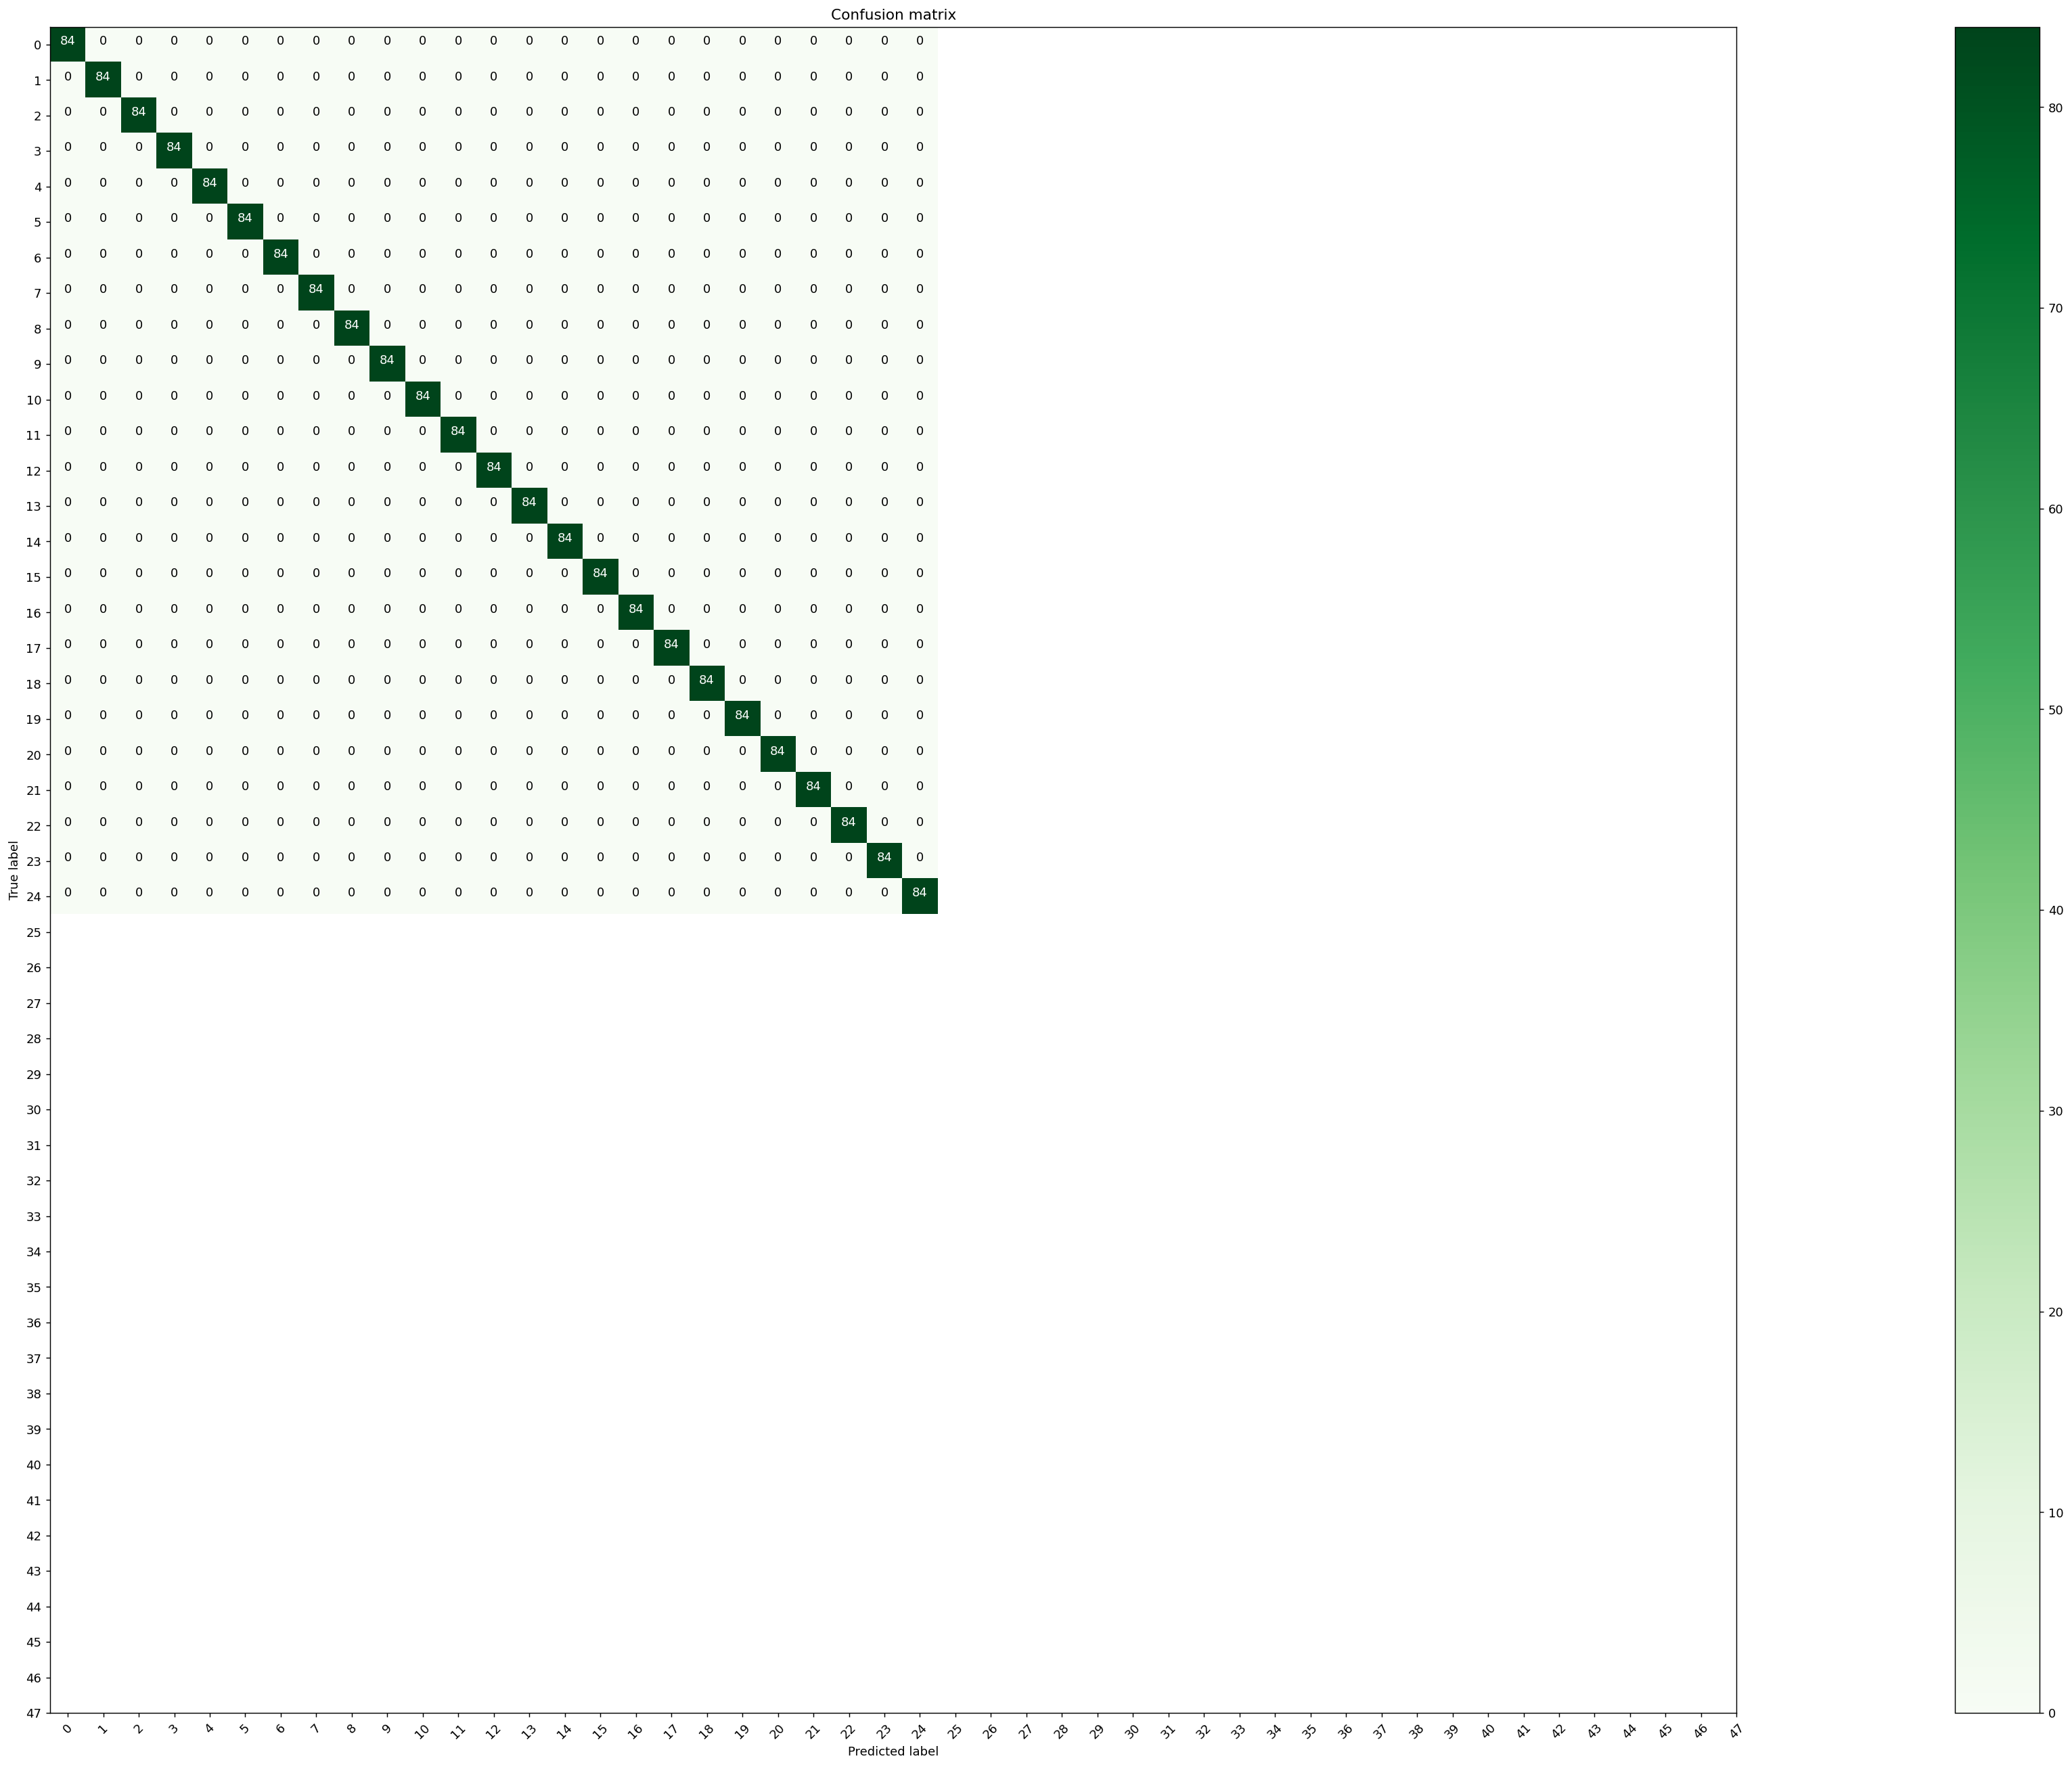

In [57]:
yp3 = clf3.predict(X_res)
CM = confusion_matrix(y_res, yp3)
plot_confusion_matrix(CM, classes = range(48))

In [58]:
from sklearn.metrics import precision_recall_fscore_support
s4 = precision_recall_fscore_support(y_res, yp3,average='weighted')
s4

(1.0, 1.0, 1.0, None)

# Using XGBoost (Extreme Gradient Boosting) as the Model and printing evaluating it using Accuracy 

In [61]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,y_train)
predictions = xgb_classifier.predict(X_test)
print("Accuracy of Model::",accuracy_score(y_test,predictions))

Accuracy of Model:: 1.0
